In [2]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [3]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [37]:
bvals_all_100206*1e3

array([   5., 1000., 1995., 3005.,  995., 2995., 2005.,  990., 1990.,
       3000., 1000., 1985., 2995., 1005., 1995., 2995.,    5.,  995.,
       2000., 3010., 3005.,  995., 2005.,  995., 1990., 2985., 1005.,
       2000., 3005.,  995., 1995., 2990.,    5., 3005.,  995., 2000.,
        990., 1990., 2990.,  995., 2985., 1995., 3005.,  995., 2005.,
       1000., 1990., 2995.,    5., 1005., 2005., 2995., 3000., 1005.,
       1985., 1005., 2985., 2005.,  995., 1990., 3005., 1000., 2990.,
       2000.,    5.,  990., 2005., 2995., 1000., 2005., 3000.,  995.,
       2005., 3005., 1005., 2000., 3010.,  990., 2005., 1995.,    5.,
       1000., 3010., 2985., 1005., 1995., 3000., 1000., 2005., 3000.,
        990., 2005., 2990., 3000., 1000.,    5., 2990.,  995., 1995.,
       1995., 1005., 2000., 2995., 1005., 2010., 2995., 1005., 2000.,
       3010., 1000., 2005., 2990.,    5.,  990., 2985., 2005., 1000.,
       2005., 2985.,  995., 2005., 2990.,  995., 2005., 2990., 1005.,
       2000., 3005.,

In [3]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]

In [4]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]

In [8]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [9]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [10]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [11]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [12]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [13]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206)

In [14]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [16]:
normalized_scan_100206.shape

(935442, 288)

In [18]:
half_normalized_scan_100206 = normalized_scan_100206[:,0:144]

In [31]:
half_bvals_100206 = bvals_all_100206[0:144]

In [32]:
half_big_b_indices_100206 = np.where(half_bvals_100206 != 0.005)[0]

In [33]:
half_big_b_indices_100206.shape

(135,)

In [29]:
half_normalized_scan_100206_no_b5 = half_normalized_scan_100206[:, half_big_b_indices_100206]

In [30]:
half_normalized_scan_100206_no_b5.shape

(935442, 135)

In [47]:
half_bvals_100206_no_5 = half_bvals_100206[half_big_b_indices_100206]

In [48]:
half_bvals_100206_no_5.shape

(135,)

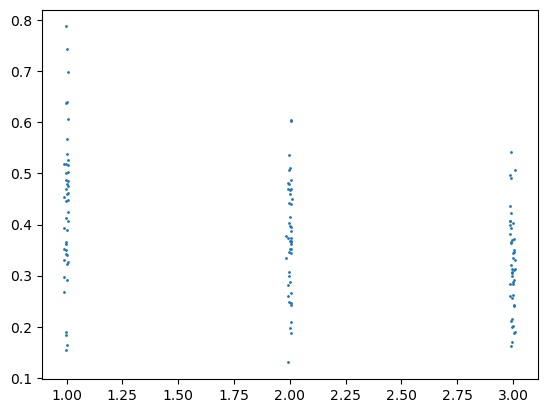

In [36]:
plt.plot(half_bvals_100206_no_5, half_normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [13]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [14]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [49]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
half_n_all_100206 = n_all_100206[:, 0:144]
half_n_100206 = half_n_all_100206[:,half_big_b_indices_100206].T
print(half_n_100206.shape)

half_b_values_100206 = torch.FloatTensor(half_bvals_100206_no_5)
half_gradient_directions_100206 = torch.FloatTensor(half_n_100206)

net = BallStickNet(half_gradient_directions_100206, half_b_values_100206)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(135, 3)


In [50]:
batch_size = 128
num_batches = len(half_normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(half_normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [53]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.29it/s]


Loss: 2612.944982022047
Average Loss: 0.35754583771511317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.18it/s]


Loss: 2611.894694775343
Average Loss: 0.3574021202484049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.50it/s]


Loss: 2609.796500712633
Average Loss: 0.3571150110444216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.51it/s]


Loss: 2610.437126249075
Average Loss: 0.35720267190053023
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.65it/s]


Loss: 2609.7895484268665
Average Loss: 0.35711405971905674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.12it/s]


Loss: 2609.8120145499706
Average Loss: 0.35711713390120015
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.72it/s]


Loss: 2609.850244373083
Average Loss: 0.3571223651304164
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.50it/s]


Loss: 2608.937194555998
Average Loss: 0.35699742673180046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.81it/s]


Loss: 2609.083992511034
Average Loss: 0.3570175140272351
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.41it/s]


Loss: 2608.8120227754116
Average Loss: 0.3569802986830065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|█▏                                                        | 152/7308 [00:02<00:43, 165.55it/s]

X_batch: 
torch.Size([128, 135])
tensor([[0.1416, 0.0677, 0.0315,  ..., 0.1448, 0.0548, 0.0576],
        [0.4828, 0.2564, 0.0918,  ..., 0.3870, 0.2455, 0.1329],
        [0.4788, 0.1685, 0.1777,  ..., 0.5337, 0.2300, 0.1769],
        ...,
        [0.5369, 0.2764, 0.2299,  ..., 0.5129, 0.2608, 0.2017],
        [0.3999, 0.2366, 0.3720,  ..., 0.5692, 0.2489, 0.3070],
        [0.6662, 0.3094, 0.3080,  ..., 0.5945, 0.1954, 0.2164]])
X_pred: 
torch.Size([128, 135])
tensor([[0.9057, 0.8206, 0.7409,  ..., 0.9060, 0.8208, 0.7429],
        [0.9057, 0.8207, 0.7409,  ..., 0.9059, 0.8208, 0.7429],
        [0.9057, 0.8207, 0.7409,  ..., 0.9059, 0.8208, 0.7430],
        ...,
        [0.9057, 0.8207, 0.7409,  ..., 0.9059, 0.8208, 0.7429],
        [0.9057, 0.8207, 0.7409,  ..., 0.9059, 0.8208, 0.7429],
        [0.9057, 0.8207, 0.7409,  ..., 0.9059, 0.8208, 0.7430]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.91it/s]


Loss: 1745.261584171094
Average Loss: 0.23881521403545347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.15it/s]


Loss: 438.8714674329385
Average Loss: 0.06005356697221381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.09it/s]


Loss: 430.55347428284585
Average Loss: 0.058915363202359856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.11it/s]


Loss: 430.16474700020626
Average Loss: 0.05886217118229423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.29it/s]


Loss: 429.84025641996413
Average Loss: 0.058817769077718136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.46it/s]


Loss: 428.8826719177887
Average Loss: 0.05868673671562516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.92it/s]


Loss: 428.897843641229
Average Loss: 0.05868881275878886
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.70it/s]


Loss: 428.4120114222169
Average Loss: 0.0586223332542716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.00it/s]


Loss: 428.5439544990659
Average Loss: 0.058640387862488486
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.04it/s]


Loss: 427.9904360892251
Average Loss: 0.05856464642709703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.75it/s]


Loss: 427.7297604472842
Average Loss: 0.05852897652535361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.22it/s]


Loss: 427.5693373091053
Average Loss: 0.05850702480967506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.47it/s]


Loss: 427.419677935075
Average Loss: 0.0584865459681274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.72it/s]


Loss: 426.8136663681362
Average Loss: 0.05840362156104764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.18it/s]


Loss: 426.83932360238396
Average Loss: 0.058407132403172406
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.37it/s]


Loss: 426.4992825917434
Average Loss: 0.05836060243455712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.87it/s]


Loss: 426.75437167007476
Average Loss: 0.05839550789136217
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.64it/s]


Loss: 426.36148991109803
Average Loss: 0.05834174738794445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.59it/s]


Loss: 426.4065498842392
Average Loss: 0.05834791322991779
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.94it/s]


Loss: 426.1855608469341
Average Loss: 0.05831767389804791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.69it/s]


Loss: 426.26766014588065
Average Loss: 0.05832890806593879
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.37it/s]


Loss: 426.2473520573694
Average Loss: 0.0583261291813587
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.26it/s]


Loss: 425.92001400585286
Average Loss: 0.05828133743922453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.94it/s]


Loss: 425.6617035274394
Average Loss: 0.058245991177810534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.80it/s]


Loss: 425.34647100628354
Average Loss: 0.05820285591218986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.12it/s]


Loss: 425.27257209131494
Average Loss: 0.05819274385485974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.99it/s]


Loss: 424.92508489172906
Average Loss: 0.05814519497697442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.89it/s]


Loss: 424.7609373535961
Average Loss: 0.058122733628023546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.78it/s]


Loss: 424.45138772414066
Average Loss: 0.058080375988524995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.22it/s]


Loss: 424.52423885883763
Average Loss: 0.05809034467143372
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.01it/s]


Loss: 424.1611827092711
Average Loss: 0.058040665395357294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.33it/s]


Loss: 424.26013107434846
Average Loss: 0.05805420512785283
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.34it/s]


Loss: 424.205116200028
Average Loss: 0.05804667709359989
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.40it/s]


Loss: 424.1482354516629
Average Loss: 0.05803889373996482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.16it/s]


Loss: 423.92101542348973
Average Loss: 0.05800780178208672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.49it/s]


Loss: 424.0585073020775
Average Loss: 0.058026615668045636
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.04it/s]


Loss: 423.61538435542025
Average Loss: 0.05796598034420091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.13it/s]


Loss: 423.93326366250403
Average Loss: 0.0580094777863306
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.83it/s]


Loss: 423.812431136379
Average Loss: 0.057992943505251644
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.20it/s]


Loss: 423.6489779308904
Average Loss: 0.05797057716624116
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.98it/s]


Loss: 423.705218230607
Average Loss: 0.05797827288322482
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.05it/s]


Loss: 423.6273037211504
Average Loss: 0.057967611346627035
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.33it/s]


Loss: 423.7105957537424
Average Loss: 0.05797900872382901
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.99it/s]


Loss: 423.2944844944868
Average Loss: 0.057922069580526384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.95it/s]


Loss: 423.62554337480105
Average Loss: 0.05796737046726889
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.09it/s]


Loss: 423.3471112840343
Average Loss: 0.05792927083799047
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.01it/s]


Loss: 423.4561893630307
Average Loss: 0.05794419668350174
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.88it/s]


Loss: 423.15858871955425
Average Loss: 0.05790347409955586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.68it/s]


Loss: 423.3974196903873
Average Loss: 0.057936154856374836
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.88it/s]


Loss: 423.1275099616032
Average Loss: 0.057899221395950086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.83it/s]


Loss: 423.21951133175753
Average Loss: 0.05791181052706042
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.95it/s]


Loss: 423.2736441933084
Average Loss: 0.05791921786991084
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.97it/s]


Loss: 423.05161820328794
Average Loss: 0.05788883664522276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.20it/s]


Loss: 422.4212737896014
Average Loss: 0.05780258262036144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.85it/s]


Loss: 420.2781087823678
Average Loss: 0.05750931975675531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.90it/s]


Loss: 419.4472751910798
Average Loss: 0.057395631525872993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.36it/s]


Loss: 419.1044387535658
Average Loss: 0.05734871904126516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.75it/s]


Loss: 418.9904291846324
Average Loss: 0.05733311838870175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.28it/s]


Loss: 418.3354017606471
Average Loss: 0.057243486830958826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.70it/s]


Loss: 418.1513121575117
Average Loss: 0.05721829668274654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.11it/s]


Loss: 417.8684847317636
Average Loss: 0.05717959561189978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.41it/s]


Loss: 417.4360731628258
Average Loss: 0.05712042599381852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.25it/s]


Loss: 417.2126218220219
Average Loss: 0.05708984972934071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.63it/s]


Loss: 416.7856920394115
Average Loss: 0.05703143021885762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.45it/s]


Loss: 416.59005216835067
Average Loss: 0.05700465957421328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.21it/s]


Loss: 416.39130871603265
Average Loss: 0.056977464246857235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.63it/s]


Loss: 415.99825102323666
Average Loss: 0.05692367966929894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.57it/s]


Loss: 415.7953398274258
Average Loss: 0.05689591404316171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.69it/s]


Loss: 415.5933078697417
Average Loss: 0.05686826872875502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.25it/s]


Loss: 415.3622718786355
Average Loss: 0.056836654608461344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.12it/s]


Loss: 415.28186636185274
Average Loss: 0.05682565221152883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.15it/s]


Loss: 415.2369826294016
Average Loss: 0.05681951048568714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.88it/s]


Loss: 414.98916746955365
Average Loss: 0.05678560036529196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.20it/s]


Loss: 414.87117084139027
Average Loss: 0.056769454138121275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.83it/s]


Loss: 414.8115454451181
Average Loss: 0.056761295216901764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.80it/s]


Loss: 414.75570458895527
Average Loss: 0.05675365415831353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.47it/s]


Loss: 414.5510986917652
Average Loss: 0.056725656635435856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.10it/s]


Loss: 414.46678287745453
Average Loss: 0.05671411916768672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.57it/s]


Loss: 414.2833390654996
Average Loss: 0.05668901738717838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.09it/s]


Loss: 414.308423089562
Average Loss: 0.05669244979331718
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.71it/s]


Loss: 414.2852215957828
Average Loss: 0.0566892749857393
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.45it/s]


Loss: 413.9961068108678
Average Loss: 0.056649713575652405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.18it/s]


Loss: 414.04689267557114
Average Loss: 0.056656662927691726
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.66it/s]


Loss: 413.85318275820464
Average Loss: 0.056630156370854494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.59it/s]


Loss: 413.83366379188374
Average Loss: 0.056627485466869694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.36it/s]


Loss: 413.7837097691372
Average Loss: 0.05662064994104231
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.47it/s]


Loss: 413.68608190654777
Average Loss: 0.05660729090127911
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.13it/s]


Loss: 413.6743330331519
Average Loss: 0.05660568322840065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.69it/s]


Loss: 413.72359774494544
Average Loss: 0.056612424431437526
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.21it/s]


Loss: 413.59156301501207
Average Loss: 0.056594357281747686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.07it/s]


Loss: 413.48704635188915
Average Loss: 0.05658005560370678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.20it/s]


Loss: 413.3770135133527
Average Loss: 0.05656499911239091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.89it/s]


Loss: 413.6335648566019
Average Loss: 0.05660010466018088
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.33it/s]


Loss: 413.4013207615353
Average Loss: 0.05656832522735842
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.80it/s]


Loss: 413.4529827362858
Average Loss: 0.056575394463093294
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.83it/s]


Loss: 413.34825358353555
Average Loss: 0.05656106370874871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.11it/s]


Loss: 413.38512277649716
Average Loss: 0.05656610875430996
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.03it/s]


Loss: 413.2928744589444
Average Loss: 0.05655348583182053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.31it/s]


Loss: 413.181893117493
Average Loss: 0.05653829955083375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.12it/s]


Loss: 413.18603094900027
Average Loss: 0.056538865756568184
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.54it/s]


Loss: 413.1315119122155
Average Loss: 0.056531405570910714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.92it/s]


Loss: 412.9849217121955
Average Loss: 0.056511346703912904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.41it/s]


Loss: 413.03037213836797
Average Loss: 0.05651756597405144
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.45it/s]


Loss: 412.99224114976823
Average Loss: 0.05651234826898854
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.98it/s]


Loss: 412.9538261513226
Average Loss: 0.05650709170105673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.20it/s]


Loss: 412.8320561395958
Average Loss: 0.056490429137875726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.32it/s]


Loss: 412.82515827636234
Average Loss: 0.05648948525949129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.80it/s]


Loss: 412.97156223561615
Average Loss: 0.0565095186419836
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.10it/s]


Loss: 412.8094402339775
Average Loss: 0.05648733446004071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.63it/s]


Loss: 412.8788986578584
Average Loss: 0.05649683889680602
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.27it/s]


Loss: 412.7253539254889
Average Loss: 0.05647582839702913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.15it/s]


Loss: 412.8060429606121
Average Loss: 0.056486869589574724
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.65it/s]


Loss: 412.625993138412
Average Loss: 0.05646223223021511
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.77it/s]


Loss: 412.69402619311586
Average Loss: 0.056471541624673764
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.79it/s]


Loss: 412.61584576335736
Average Loss: 0.05646084370051414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.75it/s]


Loss: 412.47104845009744
Average Loss: 0.05644103016558531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.36it/s]


Loss: 412.4346487140283
Average Loss: 0.056436049358788765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.25it/s]


Loss: 412.45592816756107
Average Loss: 0.05643896116140682
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.98it/s]


Loss: 412.42912894603796
Average Loss: 0.056435294053918714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.08it/s]


Loss: 412.4330894849263
Average Loss: 0.05643583599957941
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.28it/s]


Loss: 412.43781062960625
Average Loss: 0.056436482023755646
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.04it/s]


Loss: 412.40816433751024
Average Loss: 0.05643242533353999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.32it/s]


Loss: 412.4399875092786
Average Loss: 0.05643677990001075
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.40it/s]


Loss: 412.26411997689866
Average Loss: 0.056412714829898555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.31it/s]


Loss: 412.4024938051589
Average Loss: 0.05643164939862601
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.32it/s]


Loss: 412.31709787179716
Average Loss: 0.05641996413133513
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.49it/s]


Loss: 412.2995387541596
Average Loss: 0.05641756140587843
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.96it/s]


Loss: 412.16386469546705
Average Loss: 0.056398996263747544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.15it/s]


Loss: 412.24715034104884
Average Loss: 0.05641039276697439
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.50it/s]


Loss: 412.31400613021106
Average Loss: 0.05641954106872073
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.60it/s]


Loss: 412.1871291680727
Average Loss: 0.05640217968911778
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.04it/s]


Loss: 412.05779323610477
Average Loss: 0.056384481833074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.17it/s]


Loss: 412.0873145465739
Average Loss: 0.056388521421260794
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.85it/s]


Loss: 412.0269957741257
Average Loss: 0.05638026762098053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.74it/s]


Loss: 412.0003304206766
Average Loss: 0.05637661883151021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.82it/s]


Loss: 411.96918741310947
Average Loss: 0.056372357336221875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.94it/s]


Loss: 411.95847884728573
Average Loss: 0.056370892015227936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.21it/s]


Loss: 412.06628188397735
Average Loss: 0.056385643388612114
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.53it/s]


Loss: 411.9143612268381
Average Loss: 0.056364855121351684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.44it/s]


Loss: 411.9377637861762
Average Loss: 0.0563680574420055
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.30it/s]


Loss: 411.85726704611443
Average Loss: 0.05635704256241303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.72it/s]


Loss: 411.86495254957117
Average Loss: 0.0563580942186058
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.93it/s]


Loss: 411.7766206318047
Average Loss: 0.056346007201943715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.21it/s]


Loss: 411.76224635448307
Average Loss: 0.056344040278391225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.97it/s]


Loss: 411.8630820384715
Average Loss: 0.056357838264706
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.03it/s]


Loss: 411.9871028230991
Average Loss: 0.05637480881542133
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.50it/s]


Loss: 411.8042363799177
Average Loss: 0.05634978603994495
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.33it/s]


Loss: 411.77071856334805
Average Loss: 0.056345199584475654
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.61it/s]


Loss: 411.6855824517552
Average Loss: 0.05633354987024564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.31it/s]


Loss: 411.69265102315694
Average Loss: 0.05633451710771168
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.40it/s]


Loss: 411.66539321118034
Average Loss: 0.05633078724838264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.91it/s]


Loss: 411.63126112660393
Average Loss: 0.05632611673872522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.30it/s]


Loss: 411.5867814735975
Average Loss: 0.056320030305637314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.01it/s]


Loss: 411.57593693071976
Average Loss: 0.05631854637804047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.93it/s]


Loss: 411.6364202965051
Average Loss: 0.05632682270067119
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.36it/s]


Loss: 411.5868019852787
Average Loss: 0.05632003311238078
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.22it/s]


Loss: 411.64660080801696
Average Loss: 0.05632821576464381
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.50it/s]


Loss: 411.6173968377989
Average Loss: 0.056324219600136685
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.82it/s]


Loss: 411.6634308756329
Average Loss: 0.05633051872956115
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.33it/s]


Loss: 411.46156334201805
Average Loss: 0.05630289591434292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.74it/s]


Loss: 411.53808895824477
Average Loss: 0.05631336739986929
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.43it/s]


Loss: 411.5386033116374
Average Loss: 0.05631343778210693
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.15it/s]


Loss: 411.61379020405
Average Loss: 0.056323726081561304
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.85it/s]


Loss: 411.48382514272816
Average Loss: 0.056305942137757
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.31it/s]


Loss: 411.38623784366064
Average Loss: 0.05629258864855783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.29it/s]


Loss: 411.4710632364731
Average Loss: 0.056304195845166
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.12it/s]


Loss: 411.5364003898576
Average Loss: 0.05631313634234505
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.02it/s]


Loss: 411.39682179363444
Average Loss: 0.0562940369175745
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.18it/s]


Loss: 411.36896339571103
Average Loss: 0.056290224876260404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.53it/s]


Loss: 411.3831253531389
Average Loss: 0.05629216274673493
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.87it/s]


Loss: 411.47816494409926
Average Loss: 0.05630516761687182
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.72it/s]


Loss: 411.40874374704435
Average Loss: 0.056295668274089265
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.01it/s]


Loss: 411.36202158848755
Average Loss: 0.056289274984741046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.67it/s]


Loss: 411.3954810872674
Average Loss: 0.056293853460217216
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.05it/s]


Loss: 411.48661941988394
Average Loss: 0.05630632449642637
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.91it/s]


Loss: 411.3049588149879
Average Loss: 0.05628146672345209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.12it/s]


Loss: 411.33235631976277
Average Loss: 0.05628521569783289
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.16it/s]


Loss: 411.28005512757227
Average Loss: 0.056278058993920674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.56it/s]


Loss: 411.3461395967752
Average Loss: 0.056287101751063925
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.36it/s]


Loss: 411.2341927587986
Average Loss: 0.056271783355062756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.93it/s]


Loss: 411.4332218132913
Average Loss: 0.056299017763176154
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.22it/s]


Loss: 411.28464184794575
Average Loss: 0.056278686623966304
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.94it/s]


Loss: 411.23998475447297
Average Loss: 0.056272575910573754
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.50it/s]


Loss: 411.1623639045283
Average Loss: 0.056261954557269886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.96it/s]


Loss: 411.2346533900127
Average Loss: 0.056271846386153894
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.15it/s]


Loss: 411.2288216147572
Average Loss: 0.05627104838735046
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.85it/s]


Loss: 411.23937233071774
Average Loss: 0.05627249210874627
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.19it/s]


Loss: 411.457646232564
Average Loss: 0.056302359911407224
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.63it/s]


Loss: 411.15455258847214
Average Loss: 0.05626088568534102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.43it/s]


Loss: 411.15165232215077
Average Loss: 0.05626048882350175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.85it/s]


Loss: 411.258505494101
Average Loss: 0.056275110220867675
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.59it/s]


Loss: 411.2424865537323
Average Loss: 0.05627291824763715
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.51it/s]


Loss: 411.1684892033227
Average Loss: 0.05626279272076118
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.58it/s]


Loss: 411.2200250059832
Average Loss: 0.05626984469156858
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.64it/s]


Loss: 411.2310649859719
Average Loss: 0.05627135536206512
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.78it/s]


Loss: 411.1491817291826
Average Loss: 0.05626015075659313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.86it/s]


Loss: 411.14388518361375
Average Loss: 0.05625942599666307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.70it/s]


Loss: 411.06150961038657
Average Loss: 0.05624815402440977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.30it/s]


Loss: 411.01764775183983
Average Loss: 0.0562421521280569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.80it/s]


Loss: 411.0145515226759
Average Loss: 0.05624172845137875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.32it/s]


Loss: 411.05228949850425
Average Loss: 0.05624689237801098
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.27it/s]


Loss: 411.0077239093371
Average Loss: 0.056240794185733044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.82it/s]


Loss: 411.0614736280404
Average Loss: 0.05624814910071708
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.90it/s]


Loss: 411.09620305965655
Average Loss: 0.056252901349159355
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.31it/s]


Loss: 410.9614459271543
Average Loss: 0.056234461675855815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.38it/s]


Loss: 411.0762994159013
Average Loss: 0.056250177807320924
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.84it/s]


Loss: 411.04433043533936
Average Loss: 0.05624580328890796
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.09it/s]


Loss: 411.03016257146373
Average Loss: 0.056243864610216715
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.70it/s]


Loss: 411.08479783218354
Average Loss: 0.056251340699532505
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.44it/s]


Loss: 411.1320573510602
Average Loss: 0.056257807519302164
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.87it/s]


Loss: 410.9858253374696
Average Loss: 0.05623779766522572
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.13it/s]


Loss: 410.99434916698374
Average Loss: 0.056238964034891044
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.16it/s]


Loss: 410.9197387136519
Average Loss: 0.05622875461325286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.16it/s]


Loss: 410.97735023195855
Average Loss: 0.056236637962774845
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.07it/s]


Loss: 410.93651835550554
Average Loss: 0.05623105067809326
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.05it/s]


Loss: 410.98843783396296
Average Loss: 0.056238155149693894
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.63it/s]


Loss: 410.91032331297174
Average Loss: 0.05622746624424901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.88it/s]


Loss: 410.98460057238117
Average Loss: 0.05623763007284909
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.04it/s]


Loss: 410.92875411664136
Average Loss: 0.05622998824803522
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.26it/s]


Loss: 411.03963880822994
Average Loss: 0.05624516130380815
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.94it/s]


Loss: 410.87828912655823
Average Loss: 0.05622308280330572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.03it/s]


Loss: 410.8839562551584
Average Loss: 0.05622385827246284
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.29it/s]


Loss: 410.96188202360645
Average Loss: 0.05623452134969984
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.07it/s]


Loss: 411.02447289740667
Average Loss: 0.05624308605602171
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.17it/s]


Loss: 410.9266267954372
Average Loss: 0.05622969715317969
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.37it/s]


Loss: 411.04445386724547
Average Loss: 0.05624582017887869
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.41it/s]


Loss: 410.94793385034427
Average Loss: 0.05623261273266889
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.49it/s]


Loss: 410.95835038810037
Average Loss: 0.056234038093609794
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.16it/s]


Loss: 411.088392119389
Average Loss: 0.05625183252865203
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.22it/s]


Loss: 410.8439931788016
Average Loss: 0.056218389871209855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.63it/s]


Loss: 410.9358413242735
Average Loss: 0.05623095803561488
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.92it/s]


Loss: 410.88580418145284
Average Loss: 0.056224111135940454
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.76it/s]


Loss: 410.91377350129187
Average Loss: 0.05622793835540393
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.54it/s]


Loss: 410.8005057782866
Average Loss: 0.056212439214324936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.89it/s]


Loss: 410.8062965502031
Average Loss: 0.056213231602381376
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.65it/s]


Loss: 410.8471378630493
Average Loss: 0.0562188201783045
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.68it/s]


Loss: 410.9497889734339
Average Loss: 0.05623286658092965
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.39it/s]


Loss: 410.8367004438769
Average Loss: 0.056217391960026945
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.39it/s]


Loss: 410.8796595155727
Average Loss: 0.056223270322327955
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.07it/s]


Loss: 410.95600064797327
Average Loss: 0.05623371656376208
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.86it/s]


Loss: 410.850088582607
Average Loss: 0.05621922394398016
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.76it/s]


Loss: 410.8026099714916
Average Loss: 0.05621272714442961
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.36it/s]


Loss: 410.77205667225644
Average Loss: 0.0562085463426733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.19it/s]


Loss: 410.8227524124086
Average Loss: 0.056215483362398545
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.32it/s]


Loss: 410.8440299606882
Average Loss: 0.05621839490430873
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.04it/s]


Loss: 410.7955206709448
Average Loss: 0.056211757070463164
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.99it/s]


Loss: 410.76217881124467
Average Loss: 0.05620719469228854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.11it/s]


Loss: 410.8096974242944
Average Loss: 0.05621369696555753
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.26it/s]


Loss: 410.79821761953644
Average Loss: 0.05621212611104768
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.41it/s]


Loss: 410.7527291928418
Average Loss: 0.05620590164105662
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.14it/s]


Loss: 410.8443787288852
Average Loss: 0.05621844262847362
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.75it/s]


Loss: 410.6984549658373
Average Loss: 0.0561984749542744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.69it/s]


Loss: 410.78581038536504
Average Loss: 0.056210428350487826
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.94it/s]


Loss: 410.7859594321344
Average Loss: 0.056210448745502795
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.19it/s]


Loss: 410.68454695423134
Average Loss: 0.05619657183281764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.61it/s]


Loss: 410.6742141577415
Average Loss: 0.05619515793072544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.91it/s]


Loss: 410.7553259667475
Average Loss: 0.05620625697410338
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.30it/s]


Loss: 410.7811559594702
Average Loss: 0.0562097914558662
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.46it/s]


Loss: 410.6567214045208
Average Loss: 0.056192764286332894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.45it/s]


Loss: 410.65600395272486
Average Loss: 0.056192666112852334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.11it/s]


Loss: 410.70529490802437
Average Loss: 0.05619941090695462
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.41it/s]


Loss: 410.73580876528285
Average Loss: 0.05620358631161506
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.89it/s]


Loss: 410.7045407795813
Average Loss: 0.05619930771477576
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.72it/s]


Loss: 410.74726372910663
Average Loss: 0.0562051537669823
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.46it/s]


Loss: 410.62631209846586
Average Loss: 0.056188603188076884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.27it/s]


Loss: 410.6819290611893
Average Loss: 0.05619621360990549
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.49it/s]


Loss: 410.7466949922964
Average Loss: 0.05620507594311664
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.52it/s]


Loss: 410.7173403322231
Average Loss: 0.05620105915876069
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.49it/s]


Loss: 410.66389786312357
Average Loss: 0.05619374628668905
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.44it/s]


Loss: 410.66300053941086
Average Loss: 0.05619362350019306
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.16it/s]


Loss: 410.68268154375255
Average Loss: 0.05619631657686817
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.11it/s]


Loss: 410.71806723834015
Average Loss: 0.056201158625935985
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.51it/s]


Loss: 410.6634288004134
Average Loss: 0.056193682101862805
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.70it/s]


Loss: 410.59651719173416
Average Loss: 0.05618452616197785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.51it/s]


Loss: 410.6094251887407
Average Loss: 0.05618629244509315
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.47it/s]


Loss: 410.6481528719887
Average Loss: 0.05619159179967005
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.78it/s]


Loss: 410.6409107991494
Average Loss: 0.05619060082090167
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.66it/s]


Loss: 410.60551005764864
Average Loss: 0.056185756712869274
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.22it/s]


Loss: 410.6276439568028
Average Loss: 0.05618878543470208
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.81it/s]


Loss: 410.7066356642172
Average Loss: 0.05619959437112988
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.50it/s]


Loss: 410.58533996902406
Average Loss: 0.056182996711689116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.63it/s]


Loss: 410.56624843063764
Average Loss: 0.05618038429538008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.63it/s]


Loss: 410.61070218263194
Average Loss: 0.05618646718426819
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.14it/s]


Loss: 410.5652870328631
Average Loss: 0.05618025274122374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.17it/s]


Loss: 410.6638911392074
Average Loss: 0.056193745366612945
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.01it/s]


Loss: 410.6245813546702
Average Loss: 0.05618836635942395
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.38it/s]


Loss: 410.617700654082
Average Loss: 0.05618742482951314
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.10it/s]


Loss: 410.6270257064607
Average Loss: 0.056188700835585755
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.07it/s]


Loss: 410.6598538896069
Average Loss: 0.05619319292413887
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.06it/s]


Loss: 410.5284615145065
Average Loss: 0.05617521367193575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.71it/s]


Loss: 410.53180047124624
Average Loss: 0.056175670562567906
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.19it/s]


Loss: 410.5419049644843
Average Loss: 0.05617705322447787
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.54it/s]


Loss: 410.6004066595342
Average Loss: 0.05618505838253068
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.36it/s]


Loss: 410.6500940902624
Average Loss: 0.05619185742888101
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.79it/s]


Loss: 410.5557427010499
Average Loss: 0.05617894672975505
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.20it/s]


Loss: 410.6323477542028
Average Loss: 0.05618942908513996
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.22it/s]


Loss: 410.64633704023436
Average Loss: 0.05619134332789195
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.65it/s]


Loss: 410.526224282803
Average Loss: 0.056174907537329365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.52it/s]


Loss: 410.49991683708504
Average Loss: 0.056171307722644365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.97it/s]


Loss: 410.58034867281094
Average Loss: 0.05618231372096483
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.69it/s]


Loss: 410.6316678635776
Average Loss: 0.05618933605139267
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.82it/s]


Loss: 410.6353367345873
Average Loss: 0.05618983808628726
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.76it/s]


Loss: 410.5150249719154
Average Loss: 0.056173375064575176
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.56it/s]


Loss: 410.5842053766828
Average Loss: 0.056182841458221514
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.82it/s]


Loss: 410.54736342444085
Average Loss: 0.05617780014018074
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.96it/s]


Loss: 410.56769788148813
Average Loss: 0.056180582632934885
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.19it/s]


Loss: 410.5685241878964
Average Loss: 0.0561806957016826
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.69it/s]


Loss: 410.53578258678317
Average Loss: 0.0561762154606983
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.96it/s]

Loss: 410.5882413086947
Average Loss: 0.05618339372040158
Done, best loss: 410.49991683708504
Done


<All keys matched successfully>

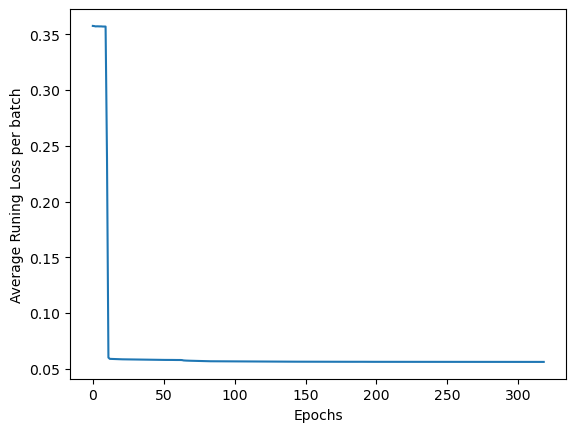

In [54]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [55]:
torch.save(final_model, 'model_100206_half_01.pt')

In [56]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=135, out_features=5, bias=True)
  )
)

In [57]:
X_100206_pred, theta_100206_pred, phi_100206_pred, mu_cart_100206_pred, lambda_par_100206_pred, lambda_iso_100206_pred,  volume_0_100206_pred, volume_1_100206_pred = net(torch.from_numpy(half_normalized_scan_100206_no_b5.astype(np.float32)))

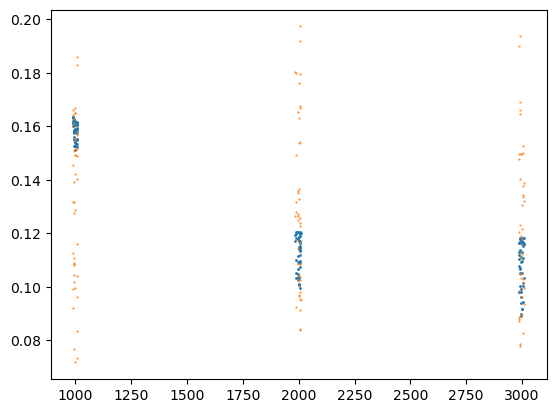

In [58]:
plt.plot(half_bvals_100206_no_5*1e03, X_100206_pred[1234,:].detach().numpy(),  "o", markersize = 1)
plt.plot(half_bvals_100206_no_5*1e03,half_normalized_scan_100206_no_b5[1234,:], ".", markersize = 1)

In [24]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [60]:
lambda_par_100206_pred_3d = back_to_3D(mask_100206_long_pro, lambda_par_100206_pred, (145, 174, 145))
lambda_iso_100206_pred_3d = back_to_3D(mask_100206_long_pro, lambda_iso_100206_pred, (145, 174, 145))
volume_0_100206_pred_3d = back_to_3D(mask_100206_long_pro, volume_0_100206_pred, (145, 174, 145))
volume_1_100206_pred_3d = back_to_3D(mask_100206_long_pro, volume_1_100206_pred, (145, 174, 145))

In [63]:
import matplotlib

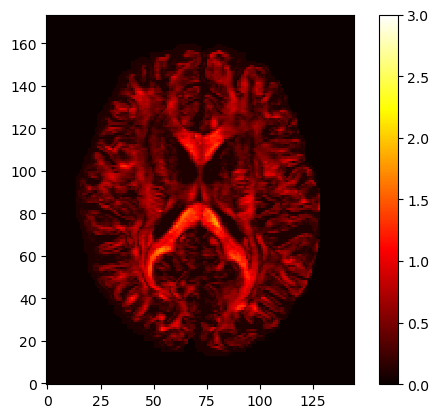

In [100]:
im = plt.imshow(lambda_par_100206_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

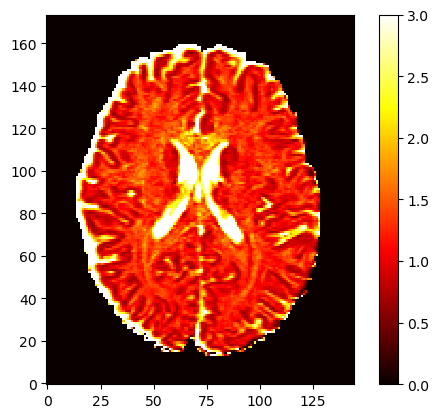

In [102]:
im = plt.imshow(lambda_iso_100206_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

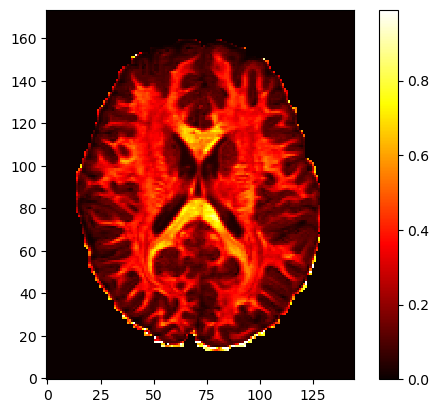

In [104]:
im = plt.imshow(volume_0_100206_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

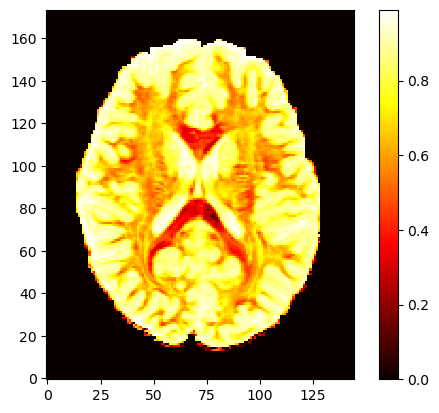

In [105]:
im = plt.imshow(volume_1_100206_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

## Test

In [18]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

In [19]:
scan_100307_dimension = scan_100307.shape
x = scan_100307_dimension[0]
y = scan_100307_dimension[1]
z = scan_100307_dimension[2]
b = scan_100307_dimension[3]

In [20]:
scan_100307_long = np.reshape(scan_100307, (x*y*z, b))
mask_100307_long = np.reshape(mask_100307, (x*y*z, 1))

In [21]:
indices_beginning_0_all_100307 = np.where(scan_100307_long[:, 0] == 0)[0]

In [22]:
mask_100307_long_pro = np.copy(mask_100307_long)
mask_100307_long_pro[indices_beginning_0_all_100307] = 0

In [111]:
scan_100307_long_no_background = process_data.remove_background(scan_100307_long, mask_100307_long_pro)

In [6]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals') * 1e-3

In [113]:
S0_100307 = process_data.get_S0(scan_100307_long_no_background, bvals_all_100307)

In [114]:
normalized_scan_100307 = scan_100307_long_no_background / S0_100307

In [5]:
normalized_scan_100307 = np.load("normalized_scan_100307_full.npy")

In [7]:
half_normalized_scan_100307 = normalized_scan_100307[:,0:144]

In [8]:
half_bvals_100307 = bvals_all_100307[0:144]

In [9]:
half_big_b_indices_100307 = np.where(half_bvals_100307 != 0.005)[0]

In [10]:
half_normalized_scan_100307_no_b5 = half_normalized_scan_100307[:, half_big_b_indices_100307]
half_bvals_100307_no_5 = half_bvals_100307[half_big_b_indices_100307]

In [11]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
half_n_all_100307 = n_all_100307[:, 0:144]
half_n_100307 = half_n_all_100307[:,half_big_b_indices_100307].T
print(half_n_100307.shape)

half_b_values_100307 = torch.FloatTensor(half_bvals_100307_no_5)
half_gradient_directions_100307 = torch.FloatTensor(half_n_100307)

(135, 3)


In [15]:
net_100307_half = BallStickNet(half_gradient_directions_100307, half_b_values_100307)
net_100307_half.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_half_01.pt"))
net_100307_half.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=135, out_features=135, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=135, out_features=5, bias=True)
  )
)

In [16]:
X_100307_half_pred, theta_100307_half_pred, phi_100307_half_pred, mu_cart_100307_half_pred, lambda_par_100307_half_pred, lambda_iso_100307_half_pred,  volume_0_100307_half_pred, volume_1_100307_half_pred = net_100307_half(torch.from_numpy(half_normalized_scan_100307_no_b5.astype(np.float32)))

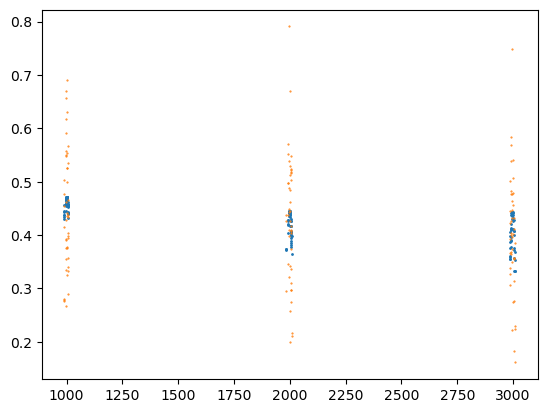

In [17]:
plt.plot(half_bvals_100307_no_5*1e03, X_100307_half_pred[1234,:].detach().numpy(),  "o", markersize = 1)
plt.plot(half_bvals_100307_no_5*1e03,half_normalized_scan_100307_no_b5[1234,:], ".", markersize = 1)

In [25]:
lambda_par_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_par_100307_half_pred, (145, 174, 145))
lambda_iso_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_iso_100307_half_pred, (145, 174, 145))
volume_0_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_0_100307_half_pred, (145, 174, 145))
volume_1_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_1_100307_half_pred, (145, 174, 145))

In [27]:
import matplotlib

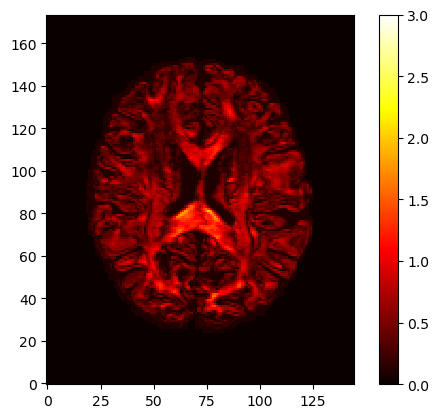

In [36]:
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

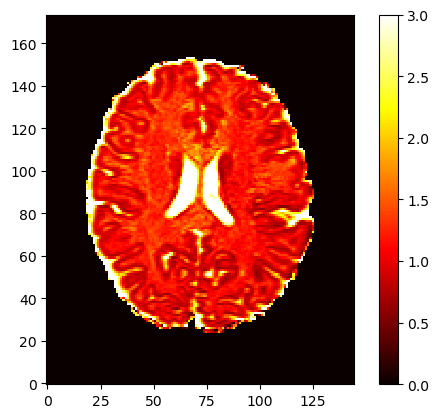

In [29]:
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

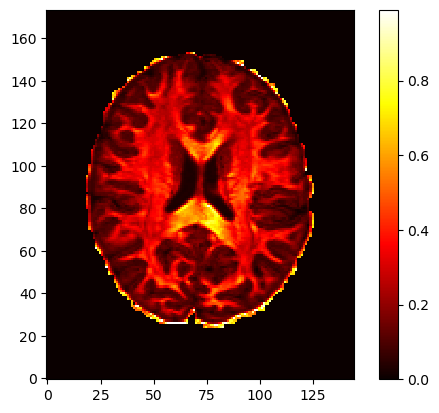

In [185]:
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

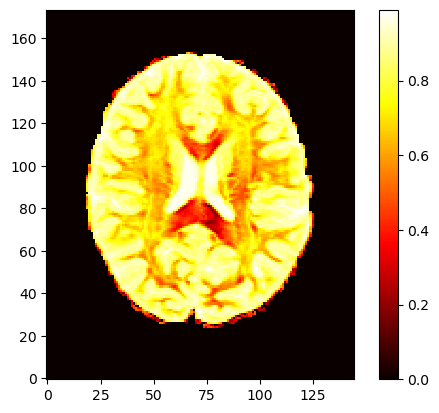

In [186]:
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

In [169]:
mu_cart_100307_half_pred.shape

torch.Size([3, 740145])

In [129]:
mask_for_mu_100307 = np.repeat(mask_100307_long_pro, 3, axis=1)

In [170]:
no_bg_indices_100307 = np.argwhere(mask_for_mu_100307 == 1)

In [171]:
resume_mu_100307 = np.copy(mask_for_mu_100307)

In [172]:
mu_cart_100307_pred_cp = np.copy(mu_cart_100307_half_pred.T.detach().numpy())

In [173]:
for i, index in enumerate(no_bg_indices_100307):
    try:
        resume_mu_100307[index[0], index[1]] = mu_cart_100307_pred_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break

In [174]:
mu_100307_reshaped = resume_mu_100307.reshape((145, 174, 145, 3))

In [177]:
volume_0_100307_slice = volume_0_100307_pred_3d[:,:,70]

In [178]:
result_v0_100307_slice = np.repeat(volume_0_100307_slice[:, :, np.newaxis], 3, axis=2)

In [179]:
mu_stick_100307 = mu_100307_reshaped[:,:,70,:] * result_v0_100307_slice

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


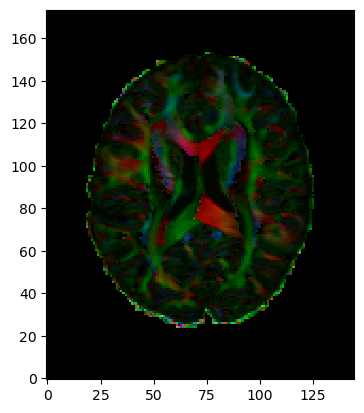

In [180]:
plt.imshow(np.rot90(mu_stick_100307, 3), origin='lower', interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


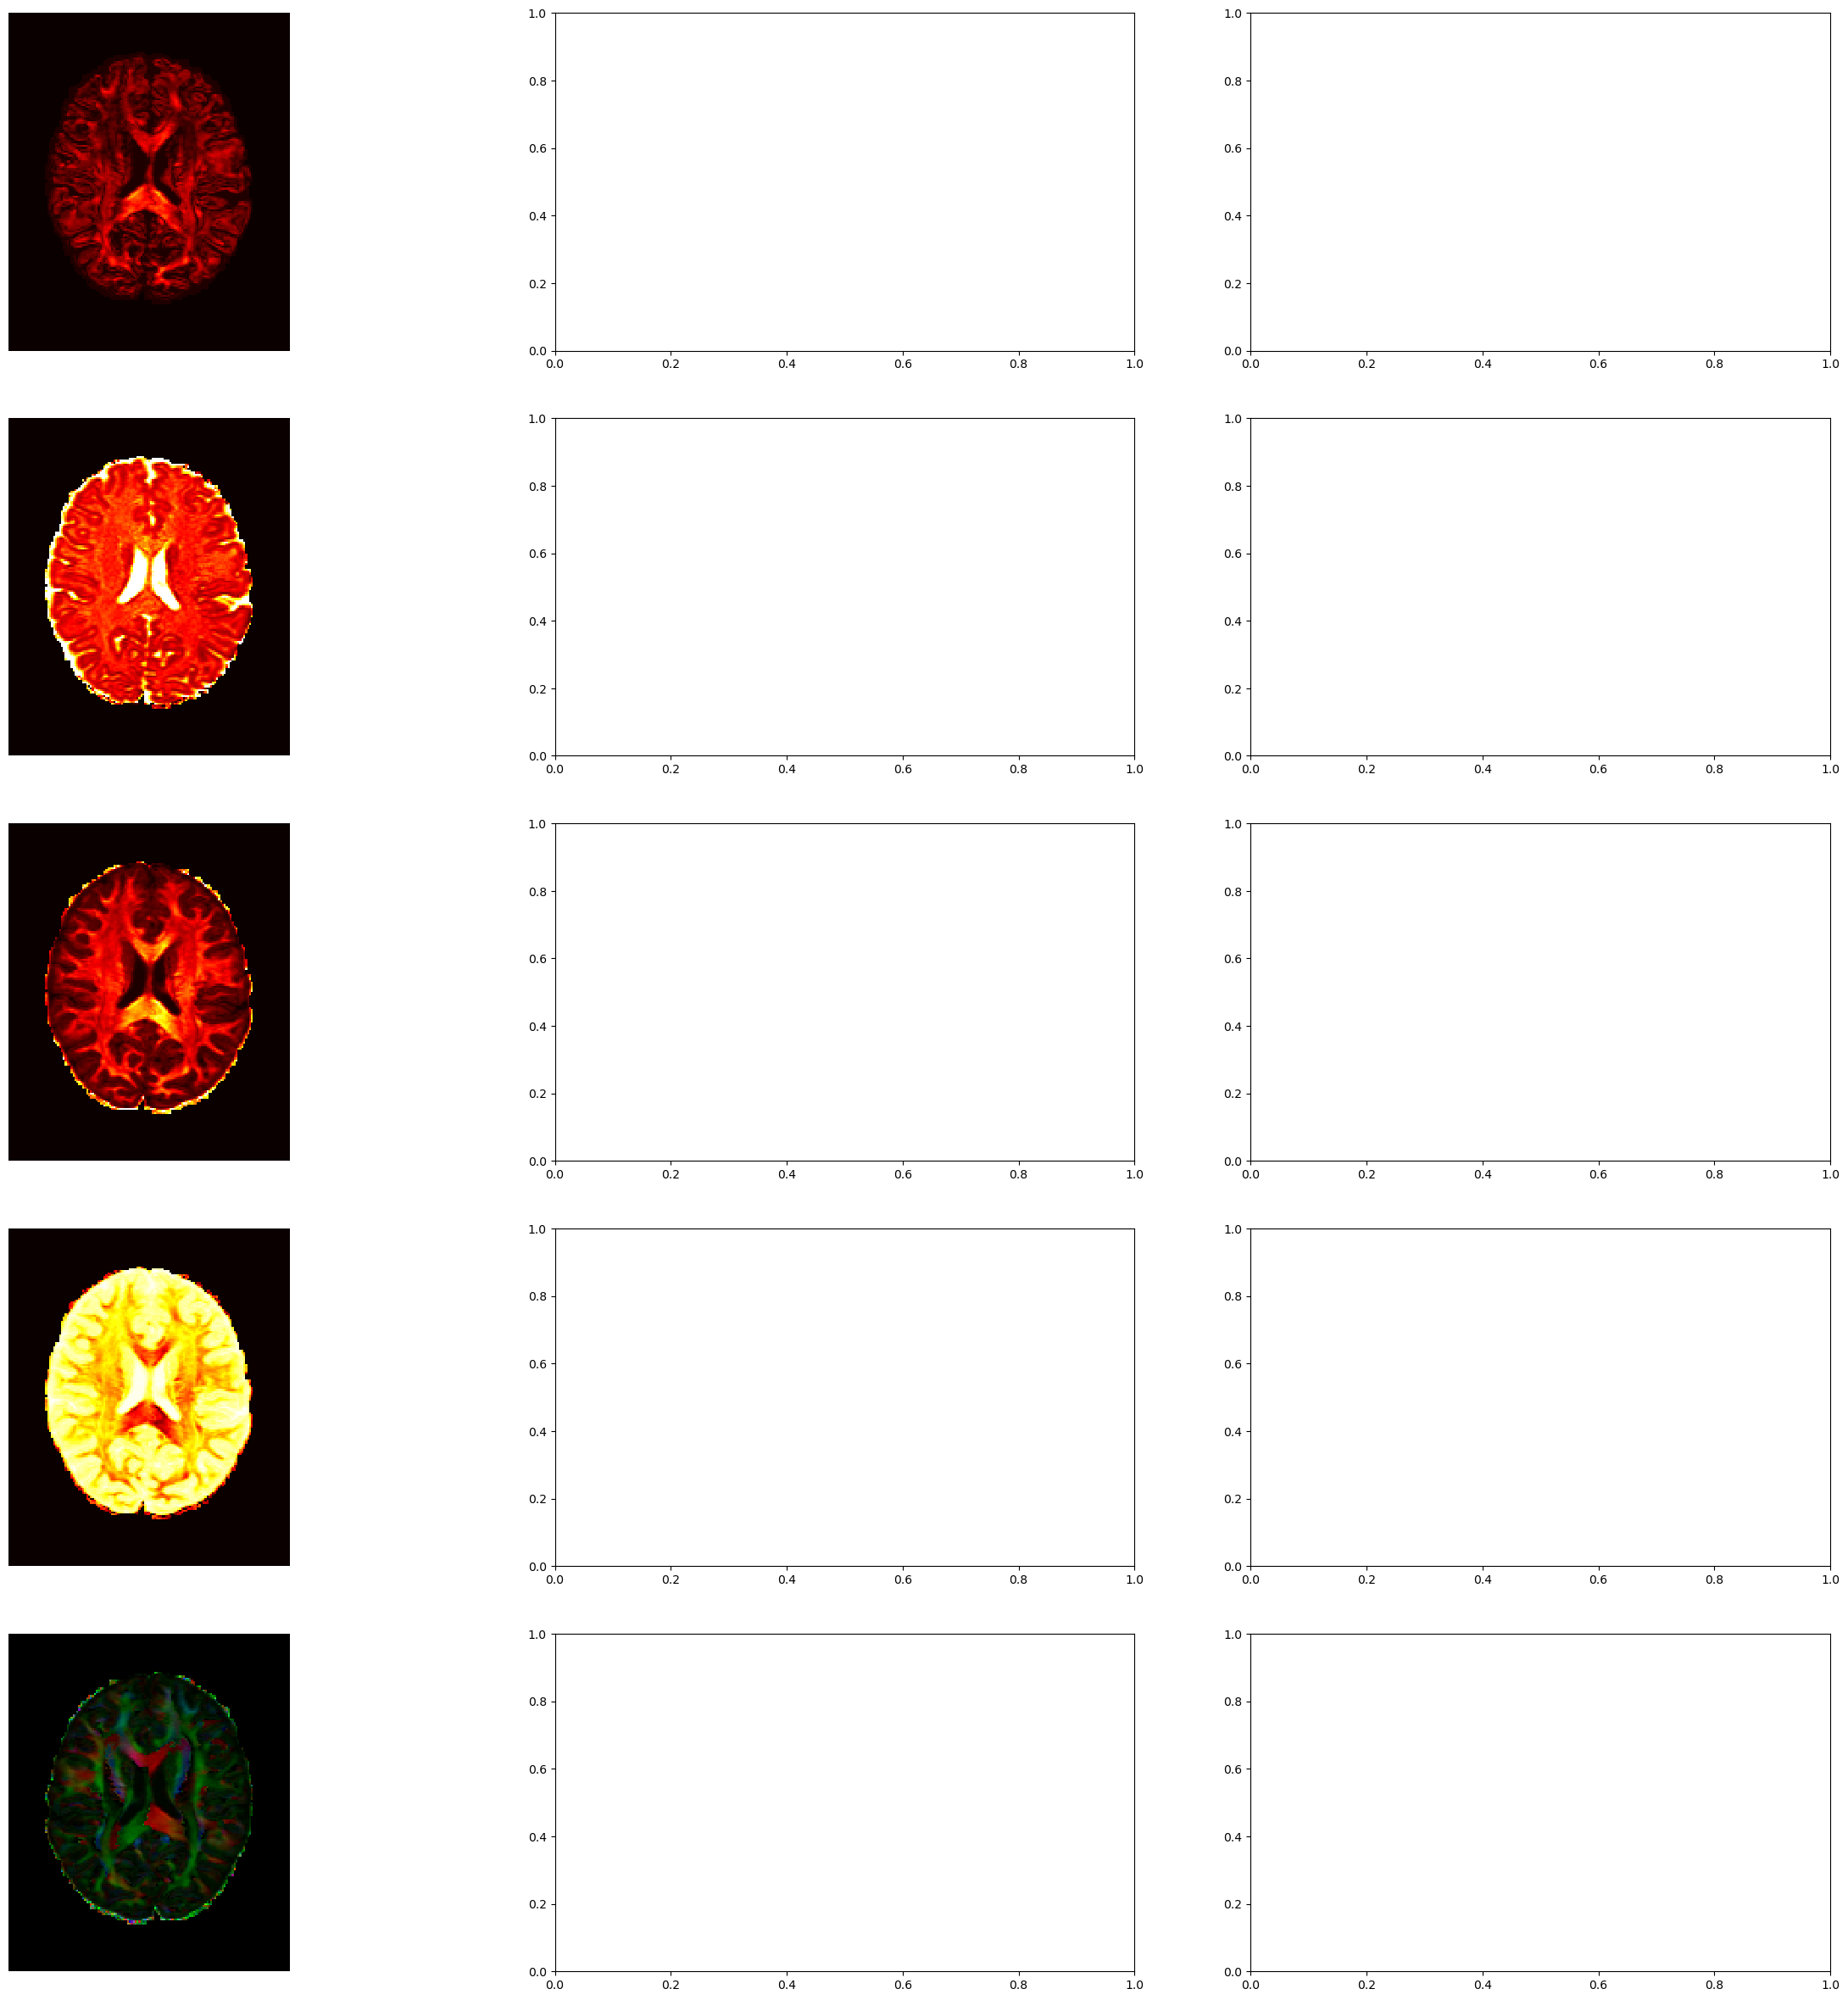

In [181]:
fig, axs = plt.subplots(5, 3, figsize=[20, 20])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"],vmin = 0, vmax = 3)
axs[0].set_axis_off()
# fig.colorbar(cf, ax=axs[0])


cf = axs[3].imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
axs[3].set_axis_off()
# fig.colorbar(cf, ax=axs[3])

cf = axs[6].imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
axs[6].set_axis_off()

cf = axs[9].imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
axs[9].set_axis_off()

cf = axs[12].imshow(np.rot90(mu_stick_100307, 3), origin='lower', interpolation='nearest')
axs[12].set_axis_off()